# Electrical Resistivity Tomography

Using the ert solver implemented provided by [PyGIMLi](https://www.pygimli.org/), 
we use different `cofi` solvers to solve the corresponding inverse problem.

<!--<badge>--><a href="https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/notebooks/pygimli_ert/pygimli_ert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

## 0. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

# !MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
# !MINICONDA_PREFIX=/usr/local
# !wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
# !chmod +x $MINICONDA_INSTALLER_SCRIPT
# !./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX
# !conda install -c gimli pygimli -y

# import sys
# _ = (sys.path.append("/usr/local/lib/python3.7/site-packages"))

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

from cofi import BaseProblem, InversionOptions, Inversion

from pygimli_ert_lib import *

np.random.seed(42)

## 1. Define the problem

We first define the true model, the survey and map it on a computational mesh designed for the survey and true anomaly.

Text(0.5, 1.0, 'Resitivity')

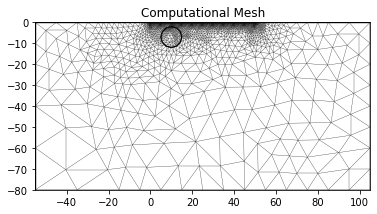

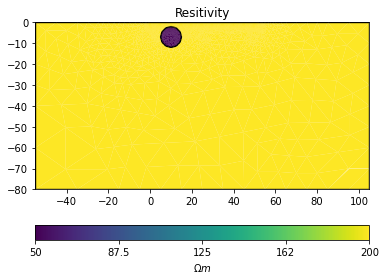

In [3]:
# PyGIMLi - define measuring scheme, geometry, forward mesh and true model
scheme = scheme_fwd()
geometry = geometry_true()
fmesh = mesh_fwd(scheme, geometry)
rhomap = markers_to_resistivity()
model_true = model_vec(rhomap, fmesh)

# plot the compuational mesh and the true model
ax=pg.show(fmesh)
ax[0].set_title("Computational Mesh")
ax=pg.show(fmesh,data=model_true,label=r"$\Omega m$")
ax[0].set_title("Resitivity")

Generate the synthetic data as a container with all the necessary information for plotting.

17/06/22 - 15:09:23 - pyGIMLi - INFO - Calculate geometric factors.


ModellingBase::setMesh() copying new mesh ... Found datafile: 51 electrodes
Found: 51 free-electrodes
rMin = 0.5, rMax = 100
NGauLeg + NGauLag for inverse Fouriertransformation: 13 + 4
Found non-Neumann domain
0.025 s
FOP updating mesh dependencies ... 0 s
Obtaining geometric factors (analytical)
Calculating response for model: min = 50 max = 200
Allocating memory for primary potential...... 0.005

No primary potential for secondary field calculation. Calculating analytically...
Factorize (Cholmod) matrix ... 0.014
Factorize (Cholmod) matrix ... 0.012
Factorize (Cholmod) matrix ... 0.011
Factorize (Cholmod) matrix ... 0.012
Factorize (Cholmod) matrix ... 0.011
Factorize (Cholmod) matrix ... 0.011
Factorize (Cholmod) matrix ... 0.011
Factorize (Cholmod) matrix ... 0.011
Factorize (Cholmod) matrix ... 0.011
Factorize (Cholmod) matrix ... 0.011
Factorize (Cholmod) matrix ... 0.011
Factorize (Cholmod) matrix ... 0.011
Factorize (Cholmod) matrix ... 0.011
Factorize (Cholmod) matrix ... 0.01

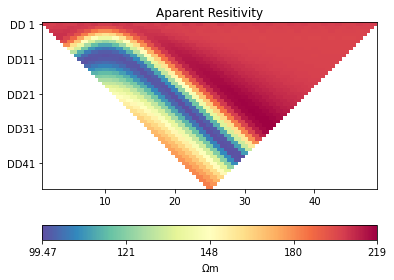

In [4]:
# PyGIMLi - generate data
survey = ert.simulate(fmesh, res=rhomap, scheme=scheme)

ax=ert.showERTData(survey,label=r"$\Omega$m")
ax[0].set_title("Aparent Resitivity")

y_obs = np.log(survey['rhoa'].array())

The inversion can use a different mesh and the mesh to be used should know nothing about the mesh that was designed based on the true model. Here we first use a triangular mesh for the inversion, which makes the problem underdetermined.

Text(0.5, 1.0, 'Inversion Mesh')

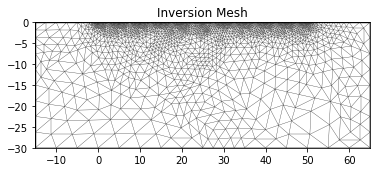

In [5]:
# PyGIMLi - create mesh for inversion
imesh_tri = mesh_inv_triangular()

ax=pg.show(imesh_tri)
ax[0].set_title("Inversion Mesh")

Define the starting model on the inversion mesh.

In [ ]:
model_0 = np.ones(imesh_tri.cellCount()) * 80.0

Setup a forward operator with the inversion mesh.

In [ ]:
forward_operator = ert.ERTModelling(
    sr=False,
    # verbose=True,
)
forward_operator.setComplex(False)
forward_operator.setData(scheme)
forward_operator.setMesh(imesh_tri, ignoreRegionManager=True)

Extract the regularisation weighting matrix defined by PyGIMLi.

In [ ]:
region_manager = forward_operator.regionManager()
region_manager.setMesh(imesh_tri) 
# region_manager.setVerbose(True)
region_manager.setConstraintType(2)
Wm = pg.matrix.SparseMapMatrix()
region_manager.fillConstraints(Wm)
Wm = pg.utils.sparseMatrix2coo(Wm)

CoFI and other inference packages require a set of functions that provide the misfit, the jacobian the residual within the case of scipy standardised interfaces. All these functions are defined in the library file `pygimli_ert_lib.py`, so open this file if you'd like to find out the details. These functions are:

- `get_response`
- `get_jacobian`
- `get_residuals`
- `get_misfit`
- `get_regularisation`
- `get_gradient`
- `get_hessian`

With all the above forward operations set up with PyGIMLi, we now define the problem in `cofi`
by setting the problem information for a `BaseProblem` object.

In [ ]:
# hyperparameters
lamda = 2

# cofi problem definition
ert_problem = BaseProblem()
ert_problem.name = "Electrical Resistivity Tomography defined through PyGIMLi"
ert_problem.set_forward(get_response, args=[forward_operator])
ert_problem.set_jacobian(get_jacobian, args=[forward_operator])
ert_problem.set_residual(get_residuals, args=[y_obs, forward_operator])
ert_problem.set_data_misfit(get_misfit, args=[y_obs, forward_operator, True])
ert_problem.set_regularisation(get_regularisation, lamda=lamda, args=[Wm, True])
ert_problem.set_gradient(get_gradient, args=[y_obs, forward_operator, lamda, Wm])
ert_problem.set_hessian(get_hessian, args=[y_obs, forward_operator, lamda, Wm])
ert_problem.set_initial_model(model_0)

Review what information is included in the `BaseProblem` object:

In [ ]:
ert_problem.summary()

## 2. Define the inversion options

In [ ]:
ert_problem.suggest_solvers();

In [ ]:
inv_options = InversionOptions()
inv_options.set_tool("scipy.optimize.minimize")
inv_options.set_params(method="L-BFGS-B")

Review what's been defined for the inversion we are about to run:

In [ ]:
inv_options.summary()

## 3. Start an inversion

In [ ]:
inv = Inversion(ert_problem, inv_options)
inv_result = inv.run()
inv_result.summary()

In [ ]:
inv_result.success

## 4. Plotting

In [ ]:
ax=pg.show(
    fmesh,
    data=(model_true),
    label=r"$\Omega m$"
)
ax[0].set_title("True model")

ax=pg.show(
    imesh_tri,
    data=(model_0),
    label=r"$\Omega m$"
)
ax[0].set_title("Starting model")


ax=pg.show(
    imesh_tri,
    data=(inv_result.model),
    label=r"$\Omega m$"
)
ax[0].set_title("Inferred model")

## 5. Use a custom solver

Now we switch to a Newton's iterative approach written by ourselves, so you'll 
have a closer look at what's happening in the loop.

First of all, define our own solver.

In [ ]:
from cofi.solvers import BaseSolver

class MyNewtonSolver(BaseSolver):
    def __init__(self, inv_problem, inv_options):
        __params = inv_options.get_params()
        self._niter = __params["niter"]
        self._step = __params["step"]
        self._verbose = __params["verbose"]
        self._model_0 = inv_problem.initial_model
        self._gradient = inv_problem.gradient
        self._hessian = inv_problem.hessian
        self._misfit = inv_problem.data_misfit if inv_problem.data_misfit_defined else None
        self._reg = inv_problem.regularisation if inv_problem.regularisation_defined else None
        self._obj = inv_problem.objective if inv_problem.objective_defined else None
        
    def __call__(self):
        current_model = np.array(self._model_0)
        for i in range(self._niter):
            term1 = self._hessian(current_model)
            term2 = - self._gradient(current_model)
            model_update = np.linalg.solve(term1, term2)
            current_model = np.array(current_model + self._step * model_update)
            if self._verbose:
                print("-" * 80)
                print(f"Iteration {i+1}")
                if self._misfit: self._misfit(current_model)
                if self._reg: self._reg(current_model)
                # if self._obj: print("objective func:", self._obj(current_model))
        return {"model": current_model, "success": True}

Now, make use of this custom solver and run inversion again:

In [ ]:
inv_options_own_solver = InversionOptions()
inv_options_own_solver.set_tool(MyNewtonSolver)
inv_options_own_solver.set_params(niter=100, step=1, verbose=True)

inv_own_solver = Inversion(ert_problem, inv_options_own_solver)
inv_own_solver_res = inv_own_solver.run()
inv_own_solver_res.summary()

In [ ]:
ax=pg.show(
    fmesh,
    data=(model_true),
    label=r"$\Omega m$"
)
ax[0].set_title("True model")

ax=pg.show(
    imesh_tri,
    data=(model_0),
    label=r"$\Omega m$"
)
ax[0].set_title("Starting model")


ax=pg.show(
    imesh_tri,
    data=(inv_own_solver_res.model),
    label=r"$\Omega m$"
)
ax[0].set_title("Inferred model")

## 6. Rectangular Mesh

Now lets do this on a rectangular mesh in the region of interests for the inversion with boundary represented using triangles.

Text(0.5, 1.0, 'Inversion Mesh')

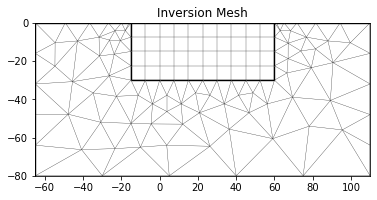

In [35]:
imesh_rect = mesh_inv_rectangular()

ax=pg.show(imesh_rect)
ax[0].set_title("Inversion Mesh")

Text(0.5, 1.0, 'Cell indices')

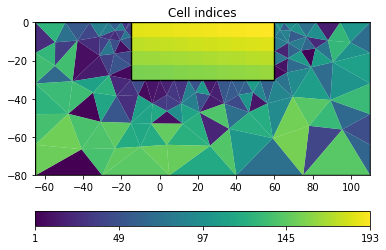

In [36]:
ax=pg.show(imesh_rect,data=np.linspace(1,imesh_rect.cellCount(),imesh_rect.cellCount()))
ax[0].set_title("Cell indices")

Again, set the starting model value.

In [37]:
model_0 = np.ones(imesh_rect.cellCount()) * 80.0

Set up the operator and regularisation for the new mesh

In [38]:
# Forward operator
forward_operator2 = ert.ERTModelling(
    sr=False,
    # verbose=True,
)
forward_operator2.setComplex(False)
forward_operator2.setData(scheme)
forward_operator2.setMesh(imesh_rect, ignoreRegionManager=True)

# Regularisation weight matrix
rm2 = forward_operator2.regionManager()
rm2.setMesh(imesh_rect) 
# rm2.setVerbose(True)
rm2.setConstraintType(2)
Wm2 = pg.matrix.SparseMapMatrix()
rm2.fillConstraints(Wm2)
Wm2 = pg.utils.sparseMatrix2coo(Wm2)

17/06/22 - 14:05:18 - Core - INFO - More than 50 regions, so we assume single regions only.
17/06/22 - 14:05:18 - Core - INFO - Applying *:* interregion constraints.


Define a new problem instance with the new forward operator.

In [39]:
# hyperparameters
lamda2 = 2

# cofi problem definition
ert_problem_rect = BaseProblem()
ert_problem_rect.name = "Electrical Resistivity Tomography defined through PyGIMLi"
ert_problem_rect.set_forward(get_response, args=[forward_operator2])
ert_problem_rect.set_jacobian(get_jacobian, args=[forward_operator2])
ert_problem_rect.set_residual(get_residuals, args=[y_obs, forward_operator2])
ert_problem_rect.set_data_misfit(get_misfit, args=[y_obs, forward_operator2])
ert_problem_rect.set_regularisation(get_regularisation, lamda=lamda2, args=[Wm2])
ert_problem_rect.set_gradient(get_gradient, args=[y_obs, forward_operator2, lamda2, Wm2])
ert_problem_rect.set_hessian(get_hessian, args=[y_obs, forward_operator2, lamda2, Wm2])
ert_problem_rect.set_initial_model(model_0)

Run the inversion with the same inversion options.

In [40]:
inv_rect = Inversion(ert_problem_rect, inv_options)
inv_rect_res = inv_rect.run()
inv_rect_res.summary()

17/06/22 - 14:05:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
17/06/22 - 14:05:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Summary for inversion result
FAILURE
----------------------------
fun: 1330.5823132055143
jac: [ 3.96242182e-02  3.64662943e-01  1.33952325e-01  3.31101641e-01
  3.99119544e-01  1.93439888e-01  6.84515461e-01  4.50182739e-01
  8.25923213e-02  4.12203033e-01  2.44594362e-01  1.20131894e-01
  1.76024032e-01 -1.24013065e-01  3.94377654e-01  4.36262000e-03
  3.68273641e-01 -7.45407623e-02  1.07633092e-01  1.06128605e+00
  1.15103322e-01  2.73767931e-01  2.79787543e-01  3.16742758e-01
  7.52875422e-02  3.32261484e-01  1.99542207e-01  2.23572421e-01
  3.12432713e-02  2.39505237e-01  9.28431762e-02  4.70635702e-01
  7.89183053e-01  8.04048661e-02  1.31104265e-01  8.09935965e-02
  4.99735118e-01  3.60046190e-01  2.82656611e-01  1.58386862e-01
  9.90357544e-02  2.73243520e-01  8.86079458e-02  7.15576839e-01
  1.85685463e-01  4.23826782e-02  4.02498496e-01  2.24425407e-02
  9.36305129e-01 -7.97878341e-02  5.86765304e-01  1.74026805e-01
 -8.52863405e-02  2.21576776e-01 -1.08554669e-02  9.89780051

Plot the results:

Text(0.5, 1.0, 'Inferred model')

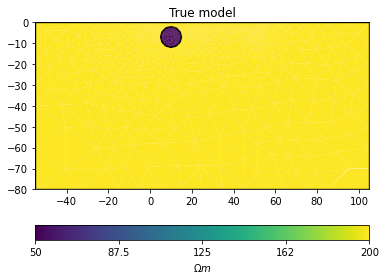

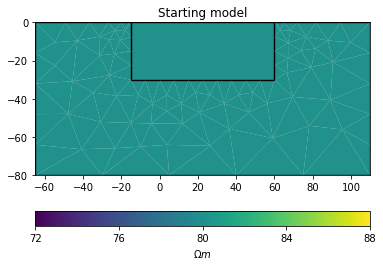

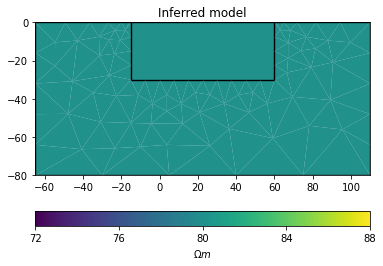

In [41]:
ax=pg.show(
    fmesh,
    data=(model_true),
    label=r"$\Omega m$"
)
ax[0].set_title("True model")

ax=pg.show(
    imesh_rect,
    data=(model_0),
    label=r"$\Omega m$"
)
ax[0].set_title("Starting model")

ax=pg.show(
    imesh_rect,
    data=(inv_rect_res.model),
    label=r"$\Omega m$"
)
ax[0].set_title("Inferred model")

## 6. Rectangular mesh with `MyNewtonSolver` and `emcee`

### 6.1. `MyNewtonSolver`

In [42]:
inv_rect_own_solver = Inversion(ert_problem_rect, inv_options_own_solver)
inv_rect_own_solver_res = inv_rect_own_solver.run()
inv_rect_own_solver_res.summary()

--------------------------------------------------------------------------------
Iteration 1
--------------------------------------------------------------------------------
Iteration 2
--------------------------------------------------------------------------------
Iteration 3
--------------------------------------------------------------------------------
Iteration 4
--------------------------------------------------------------------------------
Iteration 5
--------------------------------------------------------------------------------
Iteration 6
--------------------------------------------------------------------------------
Iteration 7
--------------------------------------------------------------------------------
Iteration 8
--------------------------------------------------------------------------------
Iteration 9
--------------------------------------------------------------------------------
Iteration 10
---------------------------------------------------------------------

Text(0.5, 1.0, 'Inferred model')

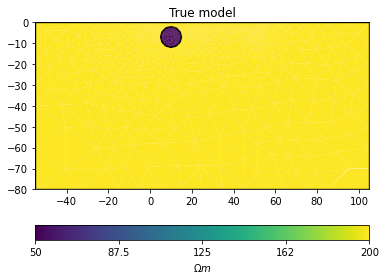

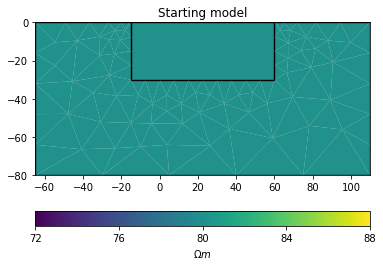

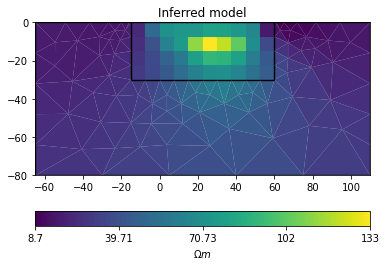

In [43]:
ax=pg.show(
    fmesh,
    data=(model_true),
    label=r"$\Omega m$"
)
ax[0].set_title("True model")

ax=pg.show(
    imesh_rect,
    data=(model_0),
    label=r"$\Omega m$"
)
ax[0].set_title("Starting model")

ax=pg.show(
    imesh_rect,
    data=(inv_rect_own_solver_res.model),
    label=r"$\Omega m$"
)
ax[0].set_title("Inferred model")

### 6.2 `emcee`

CoFI needs more assumptions about the problem for a sampler to work - these are
the log of posterior distribution density and walkers' starting positions.

For the log posterior, we define here by specifying `log_prior` and `log_likelihood`.
And CoFI will combine them to get the `log_posterior`.

In [ ]:
# define log_likelihood
sigma = 1.0                                     # common noise standard deviation
Cdinv = np.eye(len(y_obs))/(sigma**2)           # inverse data covariance matrix
def log_likelihood(model):
    residual = ert_problem_rect.residual(model)
    return -0.5 * residual @ (Cdinv @ residual).T

# define log_prior
m_lower_bound = np.zeros(model_0.shape)         # lower bound for uniform prior
m_upper_bound = np.ones(model_0.shape) * 250    # upper bound for uniform prior
def log_prior(model):                           # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

# define walkers' starting positions
nwalkers = 32
nsteps = 1000
walkers_start = model_0 + 1e-6 * np.random.randn(nwalkers, model_0.shape[0])

# define them into cofi's BaseProblem object
ert_problem_rect.set_log_likelihood(log_likelihood)
ert_problem_rect.set_log_prior(log_prior)
ert_problem_rect.set_walkers_starting_pos(walkers_start)

As usual, specify how you'd like to run the inversion and run it.

In [ ]:
# define inversion options
inv_options_emcee = InversionOptions()
inv_options_emcee.set_tool("emcee")
inv_options_emcee.set_params(nwalkers=nwalkers, nsteps=nsteps, progress=True)

from emcee.moves import GaussianMove
inv_options_emcee.set_params(moves=GaussianMove(1))

# run the inversion
inv_rect_emcee = Inversion(ert_problem_rect, inv_options_emcee)
inv_rect_emcee_res = inv_rect_emcee.run()

---
## Watermark

In [ ]:
# In case watermark doesn't work (e.g. sphinx-gallery)
watermark_list = ["cofi", "numpy", "scipy", "matplotlib", "emcee", "arviz", "pygimli"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))